
## Face Mask Detection with Data Augmentation & CNNs


In [1]:
#Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import sys
from glob import glob
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model

## Part 1: Importing the zip file from My drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Download the dataset zip in this location 
DATA_DIR = '../data'
IMAGE_DIR = '../data/images'
!mkdir ../data
!mkdir ../data/face-mask-detection
!mkdir ../data/images

Unzip the file and delete the other unnecessary files.

In [4]:
# Unzipping
shutil.unpack_archive(os.path.join('/content/drive/My Drive/face-mask-detection.zip'),DATA_DIR)

KAGGLE_DIR = os.path.join(DATA_DIR, 'face-mask-detection')
shutil.unpack_archive(os.path.join(DATA_DIR,'Dataset/train.zip'),IMAGE_DIR)
os.remove(os.path.join(DATA_DIR,'Dataset/train.zip'))
shutil.unpack_archive(os.path.join(DATA_DIR,'Dataset/test1.zip'),DATA_DIR)
os.remove(os.path.join(DATA_DIR,'Dataset/test1.zip'))
# os.remove(os.path.join(DATA_DIR,'sampleSubmission.csv'))



The with_mask and without_mask are all mixed in a single directory. The label is in the file name itself.</br>
We need to create:
1. Train, validation, and test directories, each containing a subset of the images.
2. Separate with_mask and without_mask directories _within_ train, validation, and test.

Number 2 is necessary because the Keras ImageDataGenerator's flow_from_directory() method infers the class label from the subdirectory the image resides in.

Therefore, we need to create a directory structure as seen below:


In [5]:
# face-mask-detection
# ├── test
# │   ├── with_mask
# │   └── without_mask
# ├── train
# |   ├── with_mask
# |   └── without_mask
# └── validation
#     ├── with_mask
#     └── without_mask

In [6]:
# Create train, validation, and test directories
split_dirs = ['train', 'validation', 'test']
for split_dir in split_dirs:
    # create label subdirectories
    label_dirs = ['with_mask','without_mask']
    for label_dir in label_dirs:
        new_dir = os.path.join(KAGGLE_DIR, split_dir, label_dir)
        os.makedirs(new_dir, exist_ok=True)

In [7]:
# copy dataset images into subdirectories based on probability distribution 'p'
PERCENT_OF_DATA = 0.1
np.random.seed(42)
for folder in os.listdir(IMAGE_DIR):
  for file in os.listdir(os.path.join(IMAGE_DIR,folder)):
    if not file.endswith('.png'):
        continue # skip over non-image files
    src = os.path.join(IMAGE_DIR, folder, file)
    if np.random.uniform() > PERCENT_OF_DATA:
        os.remove(src)
        continue
    dst_dir = np.random.choice(['train', 'validation', 'test'], p=[.5, .25, .25])

    if file.startswith('mask'):
        dst = os.path.join(KAGGLE_DIR, dst_dir, 'with_mask', file)
    elif file.startswith('without'):
        dst = os.path.join(KAGGLE_DIR, dst_dir, 'without_mask', file)
    try:
        shutil.move(src, dst)
    except Exception as e:
        print(e)
#Remove these empty diretories



In [8]:
#Number of images in each subdir
for dir_name in split_dirs:
    for label_dir in label_dirs:
        print(dir_name ,label_dir, len(os.listdir(KAGGLE_DIR + '/' + dir_name + '/' + label_dir)))

train with_mask 235
train without_mask 242
validation with_mask 113
validation without_mask 132
test with_mask 118
test without_mask 104


In [9]:
# Preprocessing the image into a 4D tensor
img_path = glob(KAGGLE_DIR+'/*/*/*.png')[0]

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


In [10]:
!ls

drive  sample_data


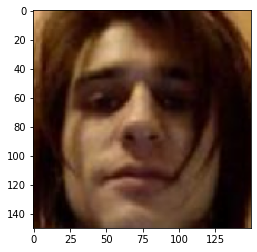

In [11]:
# Displaying an example img
plt.imshow(img_tensor[0])
plt.show()

## Part 2: Creating the Generators and training a model with only rescaled images

<b>Create the Generators</b>

Now that we have the data in the correct directory structure we can create the data generators.
Yes, that's correct. We will have _multiple_ generators, one for each split directory.<br>


First we create a main data generator object, `datagen`. This can be a given a wide range of arguments which can be used to preprocess the images it generates.</br>

<b>For right now we will only use the `rescale` argument to normalize all pixel values to between 0 and 1 (remember that 255 is the max pixel value).</b>

In [12]:
datagen = ImageDataGenerator(rescale=1/255)

Now we use `datagen`'s `flow_from_directory` method to create the 3 generators: `traingen`, `valgen`, and `testgen`.<br>

The function needs to be given the following parameters:<br>
- `directory` which they will use as their image source
- `target_size` to resize all images to (75,75)
- `batch_size`
- `class_mode` to instruct the generator on how to interpret the label folders. 

We should probably also set `shuffle = False` in the test generator so it produces the same images in the same order everytime it is used.

In [13]:
batch_size = 16
target_size = (75, 75)

traingen = datagen.flow_from_directory(directory='/data/face-mask-detection/train', target_size=target_size, batch_size=batch_size, class_mode='categorical')
 
valgen = datagen.flow_from_directory(directory='/data/face-mask-detection/validation', target_size=target_size, batch_size=batch_size, class_mode='categorical')

testgen = datagen.flow_from_directory(directory='/data/face-mask-detection/test', target_size=target_size, batch_size=batch_size, class_mode='categorical')

Found 477 images belonging to 2 classes.
Found 245 images belonging to 2 classes.
Found 222 images belonging to 2 classes.


In [14]:
print("Class Indices:", traingen.class_indices)

Class Indices: {'with_mask': 0, 'without_mask': 1}


### Construct CNN MODEL

- Build the CNN Model, there is no limitation on number of layers or size of the CNN Model, we leave the design choices to you.  For more information on layers :[CNN modelling](https://keras.io/api/layers/convolution_layers/convolution2d/)
- Fit the model using Model.fit()
- Evaluate your model 
- Plot your results
- Save your model 
We would love to see these results in Tensorboard along with the computation graph.

You can regularize the model as well. For reference: https://keras.io/api/callbacks/

In [15]:
#Creating a CNN
CNN = Sequential()

CNN.add(Input(shape=(75, 75, 3)))

#Specify a list of the number of filters for each convolutional layer

for n_filters in [16, 32, 64]:
    CNN.add(Conv2D(n_filters,strides=(2, 2), kernel_size=3, activation='relu'))

# Fill in the layer needed between our 2d convolutional layers and the dense layer
CNN.add(Flatten())

#Specify the number of nodes in the dense layer before the output
CNN.add(Dense(128, activation='relu'))

#Specify the output layer
CNN.add(Dense(2, activation='softmax'))
 
#Compiling the model
CNN.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')





**Plot Model Diagram**

<b>Fit Model</b>

Let’s fit the model to the data using the generator. You can use `fit` as before but this time you will pass it generators rather than dataframes or numpy arrays.  

Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn steps_per_epoch batches from the generator—that is, after having run for steps_per_epoch gradient descent steps - the fitting process will go to the next epoch. 

When using `fit`, you can pass a validation_data argument. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [16]:
# Training the CNN model
history = CNN.fit(traingen,
        epochs=20,
        validation_data=valgen)

Epoch 1/20
30/30 [==============================] - 10s 36ms/step - loss: 0.4484 - accuracy: 0.7925 - val_loss: 0.2242 - val_accuracy: 0.9306
Epoch 2/20
30/30 [==============================] - 1s 27ms/step - loss: 0.2004 - accuracy: 0.9371 - val_loss: 0.1405 - val_accuracy: 0.9673
Epoch 3/20
30/30 [==============================] - 1s 27ms/step - loss: 0.1709 - accuracy: 0.9455 - val_loss: 0.1516 - val_accuracy: 0.9429
Epoch 4/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1610 - accuracy: 0.9392 - val_loss: 0.1048 - val_accuracy: 0.9755
Epoch 5/20
30/30 [==============================] - 1s 27ms/step - loss: 0.0921 - accuracy: 0.9748 - val_loss: 0.1755 - val_accuracy: 0.9388
Epoch 6/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1076 - accuracy: 0.9665 - val_loss: 0.1048 - val_accuracy: 0.9592
Epoch 7/20
30/30 [==============================] - 1s 38ms/step - loss: 0.0852 - accuracy: 0.9686 - val_loss: 0.1134 - val_accuracy: 0.9673
Epoch 8/20
3

<b>Evaluate the Model</b>

In [17]:
CNN.evaluate(testgen)

14/14 [==============================] - 0s 19ms/step - loss: 0.4138 - accuracy: 0.9505


[0.41375553607940674, 0.9504504799842834]

Let’s plot the loss and accuracy of the model over the training and validation data during training:

<b>Plot the Training History</b>

Plot the training and validation accuracy and loss.

Text(0.5, 1.0, 'Accuracy Plot')

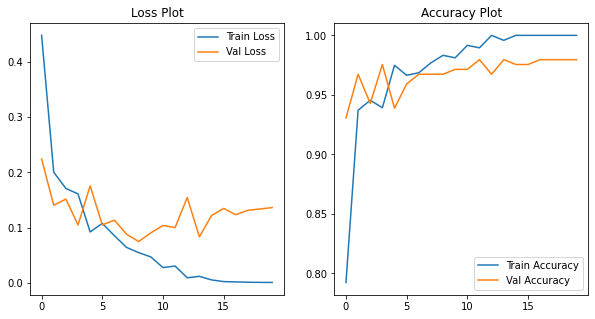

In [18]:
# Plotting the loss and accuracy plots
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(history.history['loss'], label="Train Loss")
ax[0].plot(history.history['val_loss'], label="Val Loss")
ax[1].plot(history.history['accuracy'], label="Train Accuracy")
ax[1].plot(history.history['val_accuracy'], label="Val Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Loss Plot")
ax[1].set_title("Accuracy Plot")

## Part 3: Now with Data Augmentation

We saw in the lecture on regularization that we can slightly alter our training data to similuate a larger dataset. This means our model is less likely to overfit as there is more it would have to memorize 'memorize').

Take a look again at the [ImageDataGenerator Documentation](https://keras.io/api/preprocessing/image/) to see what choices we have for changing our data. Are all changes appropriate here?</br>
Create a new data generator `datagen_aug` that preprocesses images with your chosen changes. Then we only need to make a new `traingen_aug` using `flow_from_directory`.

<b>Create Augmenting Generator</b>

These are just a few of the options available (for more, see the Keras documentation). 
Let’s quickly go over this code:

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.
- horizontal_flip is for randomly flipping half the images horizontally—relevant when there are no assumptions of - horizontal asymmetry (for example, real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift. 

Let’s look at the augmented images

In [19]:
# Augmenting the data using ImageDataGenerator
datagen_aug = ImageDataGenerator(rotation_range=180,
                                 width_shift_range=.1, height_shift_range=.1,
                                 rescale=1/255,
                                 zoom_range=.2,
                                 horizontal_flip=True)
traingen_aug = datagen_aug.flow_from_directory("/data/face-mask-detection/train", target_size=target_size,
                                               class_mode='categorical', batch_size=32)

Found 477 images belonging to 2 classes.


Let’s look at the output of one of this generator. Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, you need to break the iteration loop at some point if using a `for` loop. Better still, you can use the built in `next` function to return a signle element from the generator.

Run the below cell several times to see that different images are generated every time!

In [20]:
os.listdir('../data/face-mask-detection/train/with_mask/')

['mask- (3487).png',
 'mask- (3725).png',
 'mask- (3130).png',
 'mask- (2624).png',
 'mask- (691).png',
 'mask- (3517).png',
 'mask- (1653).png',
 'mask- (4519).png',
 'mask- (1124).png',
 'mask- (499).png',
 'mask- (3187).png',
 'mask- (3479).png',
 'mask- (1091).png',
 'mask- (1566).png',
 'mask- (3493).png',
 'mask- (4493).png',
 'mask- (2055).png',
 'mask- (2043).png',
 'mask- (1449).png',
 'mask- (3946).png',
 'mask- (4087).png',
 'mask- (3356).png',
 'mask- (4543).png',
 'mask- (1242).png',
 'mask- (1584).png',
 'mask- (4084).png',
 'mask- (1340).png',
 'mask- (1892).png',
 'mask- (901).png',
 'mask- (2161).png',
 'mask- (2404).png',
 'mask- (373).png',
 'mask- (2733).png',
 'mask- (1638).png',
 'mask- (1025).png',
 'mask- (2918).png',
 'mask- (3908).png',
 'mask- (2379).png',
 'mask- (1039).png',
 'mask- (4256).png',
 'mask- (2520).png',
 'mask- (4481).png',
 'mask- (284).png',
 'mask- (3577).png',
 'mask- (2580).png',
 'mask- (1520).png',
 'mask- (2242).png',
 'mask- (2808).png

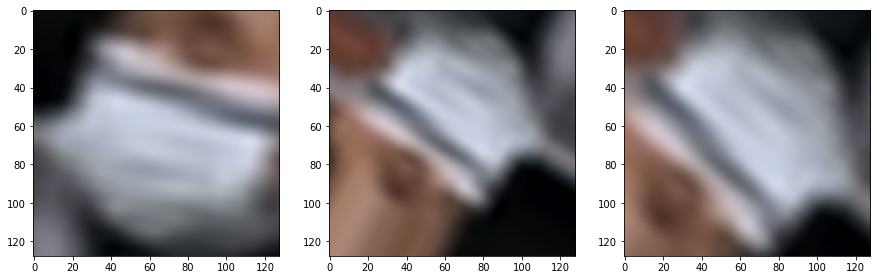

In [21]:
# Looking at the data
img = image.load_img('/data/face-mask-detection/train/with_mask/mask- (1013).png')
img = image.img_to_array(img)
img = np.array([img])
aug_iter = datagen_aug.flow(img, batch_size=1)
fig, ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
  img_aug= next(aug_iter)[0]
  ax[i].imshow(img_aug)

If you train a new network using this data-augmentation configuration, the network will never see the same input twice. But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. 

<b>2nd CNN Model</b>

To see the affect of data augmentation you should use the same architecture as your first model and the same validation data 'valgen' and test data 'testgen'.

In [22]:
#Creating a CNN
CNN_aug = Sequential()

CNN_aug.add(Input(shape=(75, 75, 3)))

#Specify a list of the number of filters for each convolutional layer

for n_filters in [16,32, 64]:
    CNN_aug.add(Conv2D(n_filters,strides=(2, 2), kernel_size=3, activation='relu'))

# Fill in the layer needed between our 2d convolutional layers and the dense layer
CNN_aug.add(Flatten())

#Specify the number of nodes in the dense layer before the output
CNN_aug.add(Dense(128, activation='relu'))

#Specify the output layer
CNN_aug.add(Dense(2, activation='softmax'))
 
#Compiling the model
CNN_aug.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

**Plot Model Diagram**


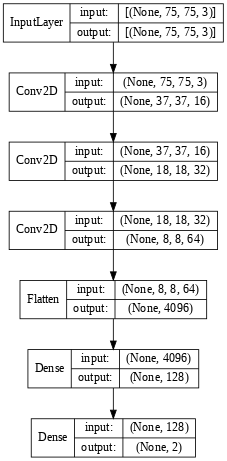

In [23]:
plot_model(CNN_aug, show_shapes=True, show_layer_names=False, dpi=60)

<b> Fit Model </b>

In [24]:
# Training the model
history_aug = CNN_aug.fit(traingen_aug,
        epochs=20,
        validation_data=valgen)

Epoch 1/20
15/15 [==============================] - 2s 102ms/step - loss: 0.6352 - accuracy: 0.6583 - val_loss: 0.3235 - val_accuracy: 0.9265
Epoch 2/20
15/15 [==============================] - 1s 95ms/step - loss: 0.4303 - accuracy: 0.8113 - val_loss: 0.2693 - val_accuracy: 0.9061
Epoch 3/20
15/15 [==============================] - 1s 95ms/step - loss: 0.3093 - accuracy: 0.8847 - val_loss: 0.2229 - val_accuracy: 0.9265
Epoch 4/20
15/15 [==============================] - 1s 95ms/step - loss: 0.2355 - accuracy: 0.9140 - val_loss: 0.1713 - val_accuracy: 0.9551
Epoch 5/20
15/15 [==============================] - 1s 94ms/step - loss: 0.2262 - accuracy: 0.9224 - val_loss: 0.1643 - val_accuracy: 0.9510
Epoch 6/20
15/15 [==============================] - 1s 94ms/step - loss: 0.2386 - accuracy: 0.9182 - val_loss: 0.1650 - val_accuracy: 0.9551
Epoch 7/20
15/15 [==============================] - 1s 92ms/step - loss: 0.2308 - accuracy: 0.9245 - val_loss: 0.1805 - val_accuracy: 0.9469
Epoch 8/20
1

<b>Plot the Training History</b>

Plot the training and validation accuracy and loss.

Text(0.5, 1.0, 'Accuracy Plot')

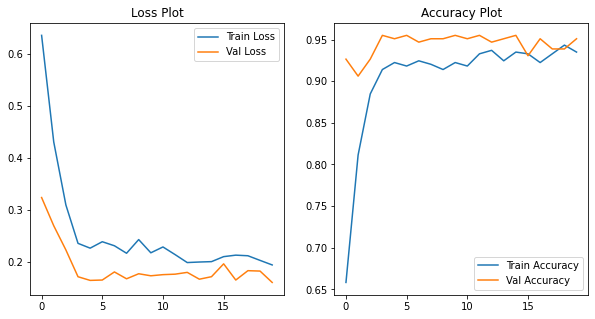

In [25]:
# Plotting the loss and accuracy plots
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(history_aug.history['loss'], label="Train Loss")
ax[0].plot(history_aug.history['val_loss'], label="Val Loss")
ax[1].plot(history_aug.history['accuracy'], label="Train Accuracy")
ax[1].plot(history_aug.history['val_accuracy'], label="Val Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Loss Plot")
ax[1].set_title("Accuracy Plot")

<b> Evaluate your model </b>

In [26]:
CNN_aug.evaluate(testgen, steps=650/batch_size)

11/40 [=======>......................] - ETA: 0s - loss: 0.2916 - accuracy: 0.8977

40/40 [==============================] - 1s 13ms/step - loss: 0.2791 - accuracy: 0.8964


[0.27909955382347107, 0.8963963985443115]

In [27]:
CNN_aug.save_weights('model_weights.h5')

In [28]:
CNN_aug_new = Sequential()

CNN_aug_new.add(Input(shape=(75, 75, 3)))

#Specify a list of the number of filters for each convolutional layer

for n_filters in [16,32, 64]:
    CNN_aug_new.add(Conv2D(n_filters,strides=(2, 2), kernel_size=3, activation='relu'))

# Fill in the layer needed between our 2d convolutional layers and the dense layer
CNN_aug_new.add(Flatten())

#Specify the number of nodes in the dense layer before the output
CNN_aug_new.add(Dense(128, activation='relu'))

#Specify the output layer
CNN_aug_new.add(Dense(2, activation='softmax'))
 
#Compiling the model
CNN_aug_new.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')



In [29]:
CNN_aug_new.load_weights('model_weights.h5')

In [30]:
from google.colab import files
files.download('/content/model_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
img = image.load_img('/data//test1/test- (1505).png',target_size=(75, 75))
img = image.img_to_array(img)
img = np.array([img])
# print(img)
aug_iter = datagen.flow(img, batch_size=1)

prediction=CNN_aug_new.predict(aug_iter)
print(prediction)
prediction

1/1 [==============================] - 0s 28ms/step
[[0.06667396 0.93332607]]


array([[0.06667396, 0.93332607]], dtype=float32)

Text(0.5, 1.0, 'No Mask Detected')

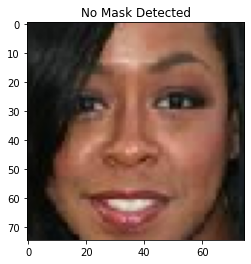

In [37]:
img = image.load_img('/data//test1/test- (1505).png',target_size=(75, 75))
plt.imshow(img)
plt.title('Mask Detected' if np.argmax(prediction)==0 else "No Mask Detected")